# Qubit Counts

The number of qubits is an important cost for running a quantum algorithm. The provided `QubitCounts()` cost key can efficiently estimate the qubit count of even large-scale algorithms by exploiting the hierarchical structure of bloq decomposition.


The number of qubits is bounded from below by the number of qubits implied by the signature.
If a bloq has no callees, the size implied by the signature will be returned. Otherwise,
`QubitCounts()` will try to compute the number of qubits by inspecting the decomposition.

In the decomposition, each (sub)bloq is considered to be executed sequentially. The "width"
of the circuit (i.e. the number of qubits) at each sequence point is the number of qubits
required by the subbloq (computed recursively) plus any "bystander" idling wires.

This is an estimate for the number of qubits required by an algorithm. Specifically:
 - Bloqs are assumed to be executed sequentially, minimizing the number of qubits potentially
   at the expense of greater circuit depth or execution time.
 - We do not consider "tetris-ing" subbloqs. In a decomposition, each subbloq is assumed
   to be using all of its qubits for the duration of its execution. This could potentially
   overestimate the total number of qubits.

This Min-Max style estimate can provide a good balance between accuracy and scalability
of the accounting. To fully account for each qubit and manage space-vs-time trade-offs,
you must comprehensively decompose your algorithm to a `cirq.Circuit` of basic gates and
use a `cirq.QubitManager` to manage trade-offs. This may be computationally expensive for
large algorithms.

In [1]:
import sympy

from qualtran.drawing import show_bloq

from qualtran.bloqs.for_testing.interior_alloc import InteriorAlloc
from qualtran.resource_counting import get_cost_value, query_costs, QubitCount

## Example: a bloq with an interior allocation

For illustrative purposes, we use a bloq that has two $n$ bit registers, but allocates an additional $n$ bit register as part of its decomposition. Looking purely at the signature, you would conclude that the bloq uses $2n$ qubits; but by looking at the decomposition we can see that at its maximum circuit width it uses $3n$ qubits. 

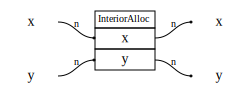

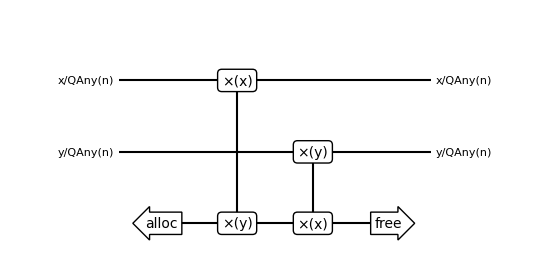

In [2]:
n = sympy.Symbol('n', positive=True, integer=True)
bloq = InteriorAlloc(n=n)
show_bloq(bloq)
show_bloq(bloq.decompose_bloq(), 'musical_score')

In [3]:
get_cost_value(bloq, QubitCount())

3*n

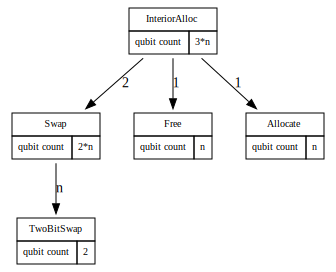

In [4]:
from qualtran.drawing import GraphvizCallGraph

g, _ = bloq.call_graph()
costs = query_costs(bloq, [QubitCount()])
GraphvizCallGraph(g, costs).get_svg()

You can call `get_cost_value` on a composite bloq directly.

In [5]:
cbloq = bloq.decompose_bloq()
get_cost_value(cbloq, QubitCount())

3*n